<a href="https://colab.research.google.com/github/nathon-tadeo/Intro-to-ML/blob/main/homework_7_intro_to_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import time
from collections import OrderedDict

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200], Loss: 1.3125, Accuracy: 0.6170
Epoch [11/200], Loss: 0.0716, Accuracy: 0.7174
Epoch [21/200], Loss: 0.0432, Accuracy: 0.7031
Epoch [31/200], Loss: 0.0412, Accuracy: 0.7024
Epoch [41/200], Loss: 0.0336, Accuracy: 0.7093
Epoch [51/200], Loss: 0.0230, Accuracy: 0.6998
Epoch [61/200], Loss: 0.0236, Accuracy: 0.7139
Epoch [71/200], Loss: 0.0340, Accuracy: 0.7028
Epoch [81/200], Loss: 0.0264, Accuracy: 0.7072
Epoch [91/200], Loss: 0.0217, Accuracy: 0.7061
Epoch [101/200], Loss: 0.0236, Accuracy: 0.7058
Epoch [111/200], Loss: 0.0220, Accuracy: 0.7087
Epoch [121/200], Loss: 0.0211, Accuracy: 0.7047
Epoch [131/200], Loss: 0.0224, Accuracy: 0.7033
Epoch [141/200], Loss: 0.0148, Accuracy: 0.7095
Epoch [151/200], Loss: 0.0222, Accuracy: 0.7067
Epoch [161/200], Loss: 0.0109, Accuracy: 0.7080
Epoch [171/200], Loss: 0.0160, Accuracy: 0.7037
Epoch [181/200], Loss: 0.0231, Accuracy: 0.7019
Epoch [191/200], Loss: 

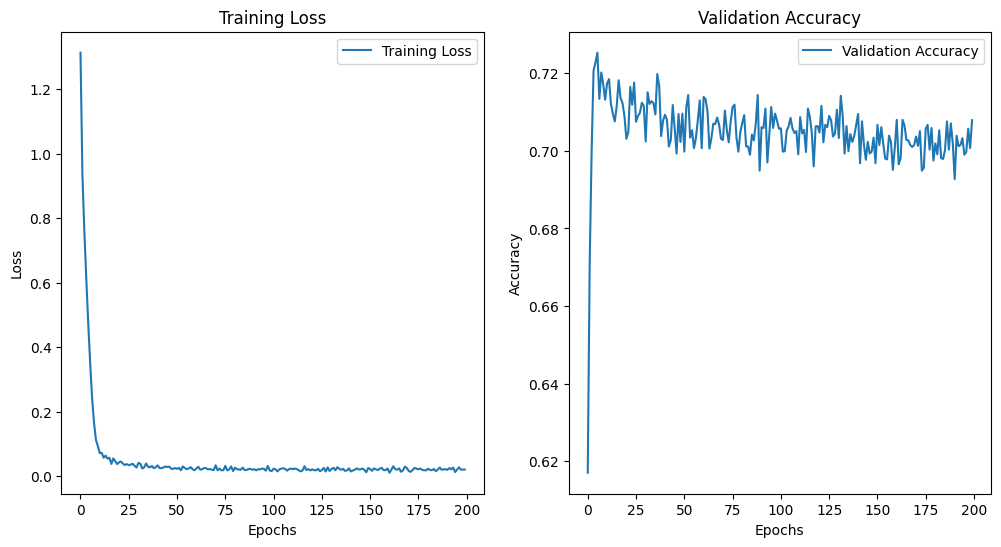

Final Test Accuracy: 0.7079


In [ ]:
#Problem 1: Build a Convolutional Neural Network, like what we built in lectures to classify the images across all 10 classes in CIFAR 10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 200
hidden_layer_size = 256

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
input_size = 3 * 32 * 32  # CIFAR-10 images are 32x32x3
num_classes = 10

# Neural Network Class
class CIFAR10CNN(nn.Module):
    def __init__(self, num_classes):
        super(CIFAR10CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pool Layer 1

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                 # Pool Layer 2
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(256, num_classes) # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Training loop
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

# Evaluate on validation data
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)
        if epoch % 10 == 0 or epoch == num_epochs -1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {val_accuracy:.4f}")


    total_time = time.time() - start_time
    return train_losses, val_accuracies, total_time

# Initialize the CNN model
model = CIFAR10CNN(num_classes).to(device)

# Loss function and optimizer remain unchanged
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop remains the same
train_losses, val_accuracies, training_time = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

print(f"\nTraining Time: {training_time:.2f} seconds")


# Training and validation losses
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.plot(range(len(train_losses)), train_losses, label='Training Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss')
ax1.legend()

ax2.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Validation Accuracy')
ax2.legend()

plt.show()

# Final evaluation on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Test Accuracy: {final_accuracy:.4f}")

Epoch [1/200], Loss: 1.3674, Accuracy: 0.6150
Epoch [11/200], Loss: 0.1175, Accuracy: 0.7548
Epoch [21/200], Loss: 0.0591, Accuracy: 0.7359
Epoch [31/200], Loss: 0.0499, Accuracy: 0.7456
Epoch [41/200], Loss: 0.0456, Accuracy: 0.7361
Epoch [51/200], Loss: 0.0433, Accuracy: 0.7428
Epoch [61/200], Loss: 0.0422, Accuracy: 0.7434
Epoch [71/200], Loss: 0.0420, Accuracy: 0.7413
Epoch [81/200], Loss: 0.0410, Accuracy: 0.7450
Epoch [91/200], Loss: 0.0307, Accuracy: 0.7311
Epoch [101/200], Loss: 0.0353, Accuracy: 0.7417
Epoch [111/200], Loss: 0.0430, Accuracy: 0.7407
Epoch [121/200], Loss: 0.0414, Accuracy: 0.7332
Epoch [131/200], Loss: 0.0438, Accuracy: 0.7358
Epoch [141/200], Loss: 0.0585, Accuracy: 0.7316
Epoch [151/200], Loss: 0.0391, Accuracy: 0.7325
Epoch [161/200], Loss: 0.0468, Accuracy: 0.7315
Epoch [171/200], Loss: 0.0422, Accuracy: 0.7345
Epoch [181/200], Loss: 0.0399, Accuracy: 0.7418
Epoch [191/200], Loss: 0.0578, Accuracy: 0.7346
Epoch [200/200], Loss: 0.0461, Accuracy: 0.7445


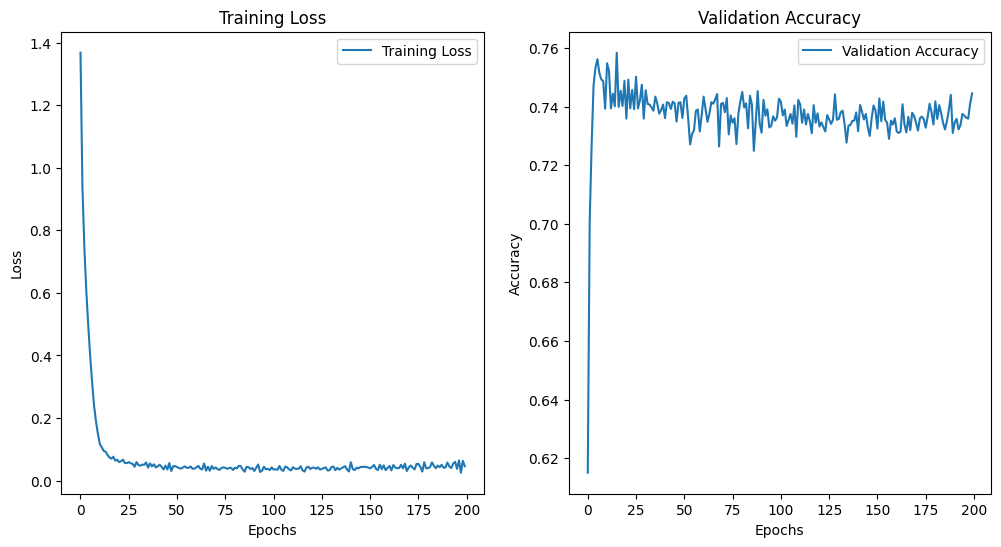


Training Time: 3910.61 seconds
Final Test Accuracy: 0.7445


In [ ]:
#1b Extend your CNN by adding one more additional convolution layer followed by an activation function and pooling function.
# Extended Neural Network Class for CNN
class ExtendedCIFAR10CNN(nn.Module):
    def __init__(self, num_classes):
        super(ExtendedCIFAR10CNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # Conv Layer 1
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pool Layer 1
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # Conv Layer 2
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),                # Pool Layer 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), # Additional Conv Layer 3
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)                 # Pool Layer 3
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),  # Adjusted fully connected layer
            nn.ReLU(),
            nn.Linear(256, num_classes)   # Output layer
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

# Initialize the extended CNN model
model = ExtendedCIFAR10CNN(num_classes).to(device)

# Loss function and optimizer remain unchanged
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with plotting
def train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate on validation data
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        # Logging metrics
        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time

    # Plot training loss and validation accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(len(train_losses)), train_losses, label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()

    ax2.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()

    plt.show()

    return train_losses, val_accuracies, total_time

# Train the model
train_losses, val_accuracies, training_time = train_model_with_plot(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Print final results
print(f"\nTraining Time: {training_time:.2f} seconds")

# Final evaluation on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"Final Test Accuracy: {final_accuracy:.4f}")


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/200], Loss: 1.3122, Accuracy: 0.6053
Epoch [11/200], Loss: 0.0729, Accuracy: 0.8351
Epoch [21/200], Loss: 0.0272, Accuracy: 0.8380
Epoch [31/200], Loss: 0.0159, Accuracy: 0.8503
Epoch [41/200], Loss: 0.0107, Accuracy: 0.8499
Epoch [51/200], Loss: 0.0088, Accuracy: 0.8514
Epoch [61/200], Loss: 0.0104, Accuracy: 0.8528
Epoch [71/200], Loss: 0.0105, Accuracy: 0.8477
Epoch [81/200], Loss: 0.0055, Accuracy: 0.8585
Epoch [91/200], Loss: 0.0071, Accuracy: 0.8565
Epoch [101/200], Loss: 0.0052, Accuracy: 0.8555
Epoch [111/200], Loss: 0.0029, Accuracy: 0.8561
Epoch [121/200], Loss: 0.0071, Accuracy: 0.8581
Epoch [131/200], Loss: 0.0035, Accuracy: 0.8571
Epoch [141/200], Loss: 0.0049, Accuracy: 0.8539
Epoch [151/200], Loss: 0.0034, Accuracy: 0.8556
Epoch [161/200], Loss: 0.0031, Accuracy: 0.8557
Epoch [171/200], Loss: 0.0015, Accuracy: 0.8602
Epoch [181/200], Loss: 0.0026, Accuracy: 0.8577
Epoch [191/200], Loss: 

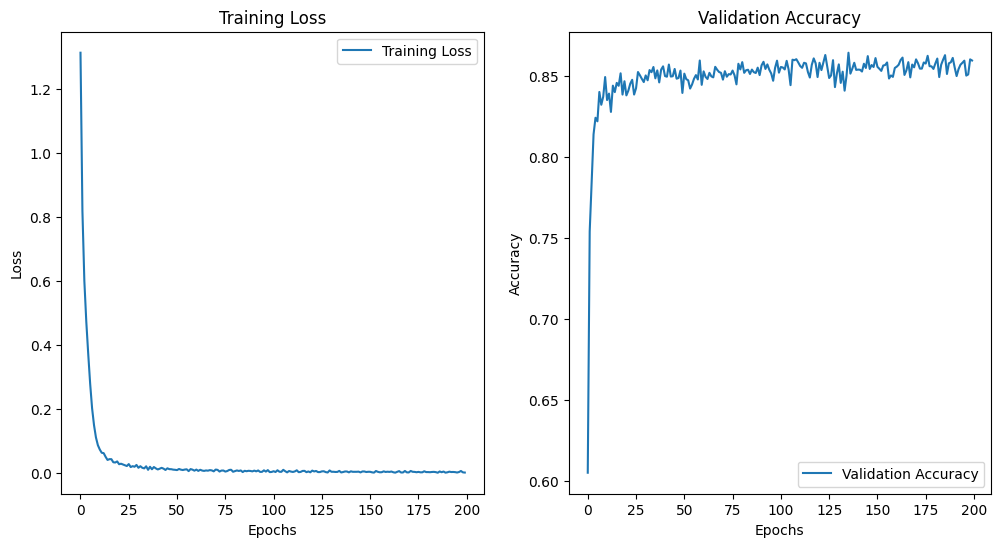


Training Time: 11802.05 seconds
Final Test Accuracy: 0.8595


In [ ]:
#Problem 2 Build a ResNet based Convolutional Neural Network to classify the images across all 10 classes in CIFAR 10
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 200
num_classes = 10

# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ResNet Block
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut for skip connection
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = nn.ReLU()(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity  # Add skip connection
        out = nn.ReLU()(out)
        return out

# ResNet-10
class ResNet10(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet10, self).__init__()
        self.in_channels = 64

        # Initial convolution layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        # ResNet blocks
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Fully connected layer
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResNetBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = nn.AdaptiveAvgPool2d((1, 1))(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model
model = ResNet10(num_classes=num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
def train_model_with_plot(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_accuracies = []
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Evaluate on validation data
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {val_accuracy:.4f}")

    total_time = time.time() - start_time

    # Plot training loss and validation accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.plot(range(len(train_losses)), train_losses, label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()

    ax2.plot(range(len(val_accuracies)), val_accuracies, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.legend()

    plt.show()

    return train_losses, val_accuracies, total_time

# Train the model
train_losses, val_accuracies, training_time = train_model_with_plot(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=num_epochs
)

# Final evaluation on the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

final_accuracy = accuracy_score(all_labels, all_preds)
print(f"\nTraining Time: {training_time:.2f} seconds")
print(f"Final Test Accuracy: {final_accuracy:.4f}")
